In [1]:
#Perform rejection sampling with the normal distribution as candidate and the t-distribution as target.
#code written by Mark Jayson Cortez for MATH 6397
import numpy as np
import seaborn as sns
import pandas as pd
import timeit
import matplotlib.pyplot as plt
from numba import jit
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import multivariate_normal
from mpl_toolkits import mplot3d
from scipy.special import gamma
from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

In [2]:
@jit
def ratio(x,mu,sigma,df,c):
    return t.pdf(x,df)/(c*norm.pdf(x,mu,sigma)) 

@jit
def rejection_sampling1(L,c,mu,sigma,df):
    y=np.zeros(L)
    i=0
    j=0
    while i<L:
        j+=1
        x=np.random.normal(mu,sigma,1)
        if np.random.uniform(0,1,1)<=ratio(x,mu,sigma,df,c):
            y[i]=x
            i+=1  
    return y,j        

@jit
def rejection_sampling2(L,c,mu,sigma,df):
    y=np.zeros(L)
    i=j=0
    while i<L:
        j+=1
        x=np.random.normal(mu,sigma,1)
        if np.random.uniform(0,1,1)<=ratio(x,mu,sigma,df,c):
            y[i]=x
            c_star=np.maximum(c,c*ratio(x,mu,sigma,df,c))
            c=c_star
            i+=1  
    return y,c,j 

@jit
def sup_norm(y,z,z_min,z_max):
    grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(0.1, 1.0, 30)},cv=10)
    grid.fit(y[:,None])
    kde = grid.best_estimator_ 
    z_grid = np.linspace(z_min,z_max,10000)
    pdf_kde = np.exp(kde.score_samples(z_grid[:,None])) 
    error = np.max(np.absolute(np.subtract(z,pdf_kde)))
    return error

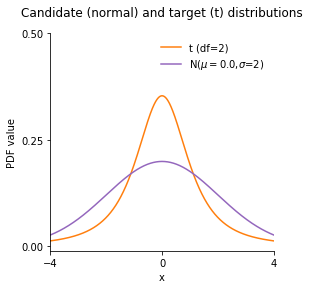

In [3]:
#Description of target and candidate distribution
mu=0
sigma=2
df=2
z_min=-5
z_max=5
z=t.pdf(np.linspace(z_min,z_max,10000),df)
f=plt.figure(figsize=(4,4))
plt.plot(np.linspace(z_min,z_max,10000),z,c='C1',label=r't (df=%d)' %df )
plt.plot(np.linspace(z_min,z_max,10000),norm.pdf(np.linspace(z_min,z_max,10000),mu,sigma),c='C4',label='N($\mu=%1.1f$,$\sigma$=%d)' %(mu,sigma))
plt.xlim([-4,4])
plt.yticks(np.linspace(0,0.5,3))
plt.xticks(np.linspace(-4,4,3))
plt.ylabel('PDF value')
plt.xlabel('x')
plt.legend(frameon=False)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.title('Candidate (normal) and target (t) distributions',y=1.05)
plt.show()

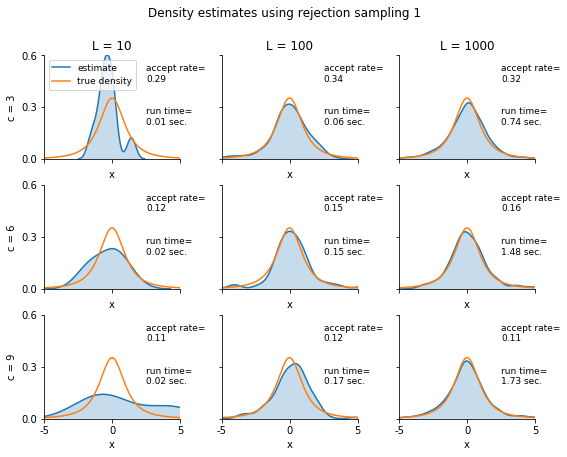

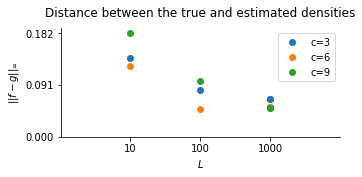

In [5]:
L=[10,100,1000]
c=[3,6,9]
M=len(c)   #M is length of vector c
N=len(L)   #N is length of vector L

error = np.zeros([M,N])
f, axes = plt.subplots(M,N,figsize=(8,6))
for i in range(M):   #i is c index
    for j in range(N):  #j is L index
        start = timeit.default_timer()
        y,iteration=rejection_sampling1(L[j],c[i],mu,sigma,df)
        stop = timeit.default_timer()
        error[i,j]=sup_norm(y,z,z_min,z_max)
        sns.kdeplot(y,label='estimate',shade=True,ax=axes[i,j])
        axes[i,j].plot(np.linspace(z_min,z_max,10000),z,label='true density')
        axes[i,j].text(2.5,0.2,f'run time=\n%1.2f sec.' %(stop-start),fontsize=9)
        axes[i,j].text(2.5,0.45,f'accept rate=\n%1.2f' %(L[j]/iteration),fontsize=9)
        axes[i,j].set_xlim([z_min,z_max])
        axes[i,j].set_ylim([0,0.6])
        axes[i,j].set_xticks(np.linspace(z_min,z_max,3))
        axes[i,j].set_yticks(np.linspace(0,0.6,3))
        axes[i,j].set_xticklabels([])
        axes[i,j].set_yticklabels([]) 
        axes[i,j].set_xlabel('x')
        axes[i,j].legend([],frameon=False)
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')
        if i==0:
            axes[i,j].set_title('L = %d' %(L[j]))
        if j==0:
            axes[i,j].set_ylabel('c = %d' %(c[i]))
            axes[i,j].set_yticklabels(np.linspace(0,0.6,3))   
        if i==M-1:
            axes[i,j].set_xticklabels(np.linspace(z_min,z_max,3).astype(int))        
plt.tight_layout(h_pad=0.1,w_pad=1)      
axes[0,0].legend(loc='upper left',fontsize=9)
f.suptitle('Density estimates using rejection sampling 1',y=1.05)
plt.show()
#f.savefig('algorithm1.png', format='png', dpi=500,bbox_inches="tight")

f = plt.figure(figsize=(5,2))
col=['C0','C1','C2']
labels=['c=3','c=6','c=9']
for j in range(N): 
    for i in range(M):       
        plt.scatter([j+1],error[i,j],c=col[i])
        if j==N-1:
            plt.scatter([j+1],error[i,j],c=col[i],label=labels[i])
plt.xlim([0,4])
plt.xticks([1,2,3],L)
plt.yticks(np.linspace(0,np.max(error),3))
plt.legend()
plt.ylabel(r'$\|| f-g \||_\infty$')
plt.xlabel(r'$L$')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.title('Distance between the true and estimated densities',y=1.05)
plt.show()

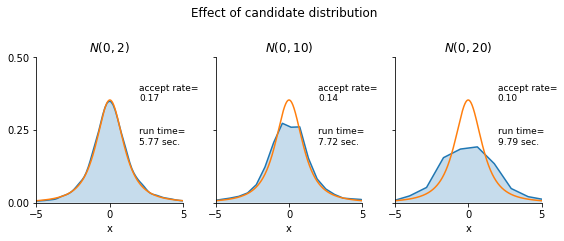

In [6]:
mu=0
sigma=[2,10,20]
df=2
z=t.pdf(np.linspace(-5,5,10000),2)
c=6
L=5000
f, axes = plt.subplots(1,N,figsize=(8,3))
for i in range(3):
    start = timeit.default_timer()
    y,iteration=rejection_sampling1(L,c,mu,sigma[i],df)
    stop = timeit.default_timer()
    sns.kdeplot(y,shade=True,ax=axes[i])
    axes[i].text(2,0.2,f'run time=\n%1.2f sec.' %(stop-start),fontsize=9)
    axes[i].text(2,0.35,f'accept rate=\n%1.2f' %(L/iteration),fontsize=9)
    axes[i].plot(np.linspace(z_min,z_max,10000),z,label='true density')
    axes[i].set_xlim([z_min,z_max])
    axes[i].set_ylim([0,0.5])
    axes[i].set_xticks(np.linspace(z_min,z_max,3))
    axes[i].set_yticks(np.linspace(0,0.5,3))
    axes[i].set_xlabel('x')
    axes[i].spines['right'].set_color('none')
    axes[i].spines['top'].set_color('none')
    axes[i].set_title(r'$N(0,%1.0f)$' %(sigma[i]))
    if i>0:
        axes[i].set_yticklabels([])
plt.suptitle('Effect of candidate distribution',y=1.1)
plt.tight_layout(h_pad=0.1,w_pad=0.5)  
plt.show()

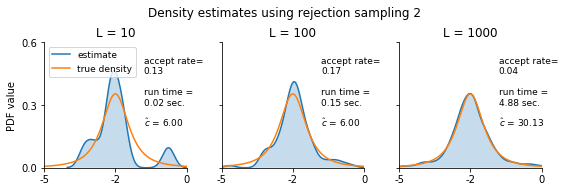

In [8]:
mu=0
sigma=2
df=2
c=6
L=[10,100,1000]
f, axes = plt.subplots(1,N,figsize=(8,2.5))
for j in range(N):  #j is L index
    start = timeit.default_timer()
    y,c_star,iteration=rejection_sampling2(L[j],c,mu,sigma,df)
    stop = timeit.default_timer()
    sns.kdeplot(y,label='estimate',shade=True,ax=axes[j])
    axes[j].plot(np.linspace(z_min,z_max,10000),z,label='true density')
    axes[j].text(2,0.45,f'accept rate=\n%1.2f' %(L[j]/iteration),fontsize=9)
    axes[j].text(2,0.3,f'run time =\n%1.2f sec.' %(stop-start),fontsize=9)
    axes[j].text(2,0.2,r'$\hat{c}$ = %1.2f' %(c_star),fontsize=9)
    axes[j].set_xlim([z_min,z_max])
    axes[j].set_ylim([0,0.6])
    axes[j].set_xticks(np.linspace(z_min,z_max,3))
    axes[j].set_yticks(np.linspace(0,0.6,3))
    axes[j].set_xticklabels(np.linspace(z_min,z_max,5).astype(int))
    axes[j].set_yticklabels([])        
    axes[j].legend([],frameon=False)
    axes[j].spines['right'].set_color('none')
    axes[j].spines['top'].set_color('none')
    axes[j].set_title('L = %d' %(L[j]))    
    axes[j].set_label('x')
axes[0].set_ylabel('PDF value')
axes[0].set_yticklabels(np.linspace(0,0.6,3))   
plt.tight_layout(h_pad=0.1,w_pad=1)      
axes[0].legend(loc='upper left',fontsize=9)
f.suptitle('Density estimates using rejection sampling 2',y=1.05)
plt.show()
#f.savefig('algorithm2.png', format='png', dpi=500,bbox_inches="tight")

# Multivariate version

In [12]:
def plot_density(X,Y,z):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.plot_wireframe(X, Y, z, color='green')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticks([-3,0,3])
    ax.set_yticks([-3,0,3])
    ax.set_zticks(np.linspace(0,0.14,3))
    ax.plot_surface(X, Y, z, rstride=1, cstride=1,cmap='winter_r', edgecolor='none')
    ax.set_title('True density')
    
def plot_samples(sample):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(sample[0,:], sample[1,:],range=[[-3, 3], [-3, 3]],density=True)
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',color='C0')
    ax.set_xticks([-3,3])
    ax.set_yticks([-3,3])
    ax.set_zticks(np.linspace(0,0.14,3))
    ax.set_title('Density estimate')

def plot_contour(X,Y,z,sample):
    sns.kdeplot(sample[0,:],sample[1,:],cmap='winter_r',shade=True,ax=axes[1])
    axes[0].contourf(X,Y,z,cmap='winter_r')
    for i in range(2):
        axes[i].set_xlim([-3,3])
        axes[i].set_ylim([-3,3])
        axes[i].set_xticks([-3,0,3])
        axes[i].set_yticks([-3,0,3])
        axes[i].spines['right'].set_color('none')
        axes[i].spines['top'].set_color('none')
    axes[1].set_title('Density contour estimate')
    axes[0].set_title('True density contour')
    axes[1].text(1,2,f'run time =\n%1.2f sec.' %(stop-start),fontsize=9)
    axes[i].text(1,1,f'accept rate=\n%1.2f' %(L/iteration),fontsize=9)

@jit
def t_pdf(x,mu,df,sigma):
    p=np.shape(sigma)[1]
    ex=p/2
    A=gamma((df+p)/2)
    B=gamma(df/2)*(df**ex)*(np.pi**ex)*np.sqrt(np.linalg.det(sigma))
    C=(1+((1/df)*np.dot(np.dot((x-mu),np.linalg.inv(sigma)),np.transpose(x-mu))))**(-(df+p)/2)
    return A*C/B

@jit
def twod_ratio(x,df,mu_t,mu_normal,cov_t,cov_normal,c):
    return t_pdf(x,mu_t,df,cov_t)/(c*multivariate_normal.pdf(x,mu_normal,cov_normal)) 

@jit
def twod_rejection_sampling_1(df,mu_t,mu_normal,cov_t,cov_normal,c,L):
    y=np.zeros([len(mu_t),L])
    i=j=0
    while i<L:
        j+=1
        x=np.random.multivariate_normal(mu_normal,cov_normal,1)
        if np.random.uniform(0,1,1)<=twod_ratio(x,df,mu_t,mu_normal,cov_t,cov_normal,c):
            y[:,i]=x
            i+=1  
    return y,j 

@jit
def twod_rejection_sampling_2(df,mu_t,mu_normal,cov_t,cov_normal,c,L):
    y=np.zeros([len(mu_t),L+1])
    i=j=0
    rho=cov_normal[0,1]/np.sqrt(cov_normal[0,0]*cov_normal[1,1])
    while i<L:
        j+=1
        cond_mu = mu_normal[i%2]+np.sqrt(cov_normal[i%2,i%2])*rho*(y[(i+1)%2,i]-mu_normal[(i+1)%2])/np.sqrt(cov_normal[(i+1)%2,(i+1)%2])
        x=np.random.normal(cond_mu,np.sqrt(cov_normal[i%2,i%2]*(1-rho**2)),1) 
        if i%2==0:
            prop=np.array([y[0,i],x])
        else:
            prop=np.array([x,y[1,i]])     
        if np.random.uniform(0,1,1)<=twod_ratio(prop,df,mu_t,mu_normal,cov_t,cov_normal,c):
                y[:,i+1]=prop
                i+=1           
    return y,j 

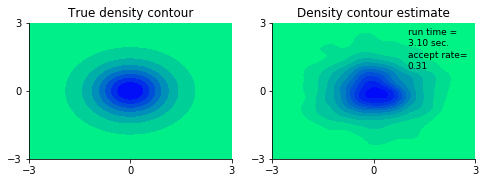

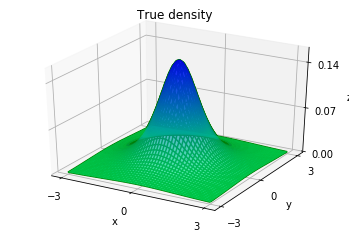

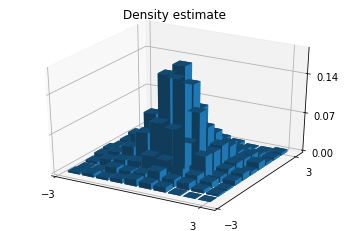

In [13]:
mu_t = np.array([0, 0])
mu_normal = np.array([0, 0])
cov_normal = np.array([[2, 0], [0, 2]])
cov_t = np.array([[1, 0], [0, 1]])
df=2
c=3
L=2000
start = timeit.default_timer()
sample,iteration=twod_rejection_sampling_1(df,mu_t,mu_normal,cov_t,cov_normal,c,L)
stop = timeit.default_timer()
       
f, axes = plt.subplots(1,2,figsize=(8,2.5))
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
z=np.zeros([500,500])
for i in range(500):
        for j in range(500):
            z[i,j]= t_pdf([X[i,j],Y[i,j]],mu_t,df,cov_t)  
plot_contour(X,Y,z,sample)    
plot_density(X,Y,z)
plot_samples(sample)

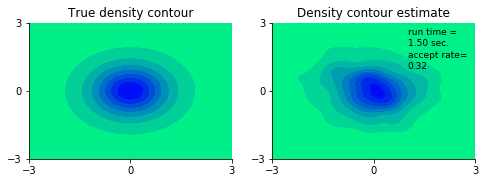

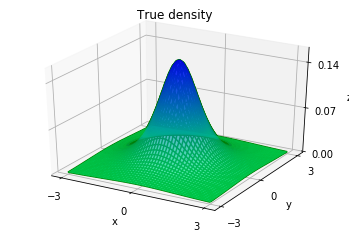

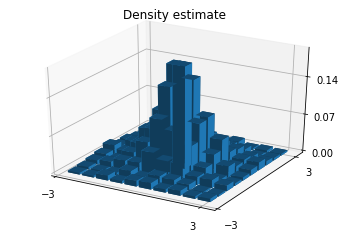

In [15]:
mu_t = np.array([0, 0])
mu_normal = np.array([0, 0])
cov_normal = np.array([[2, 0], [0, 2]])
cov_t = np.array([[1, 0], [0, 1]])
df=2
c=3
L=2000
start = timeit.default_timer()
sample,iteration=twod_rejection_sampling_2(df,mu_t,mu_normal,cov_t,cov_normal,c,L)
stop = timeit.default_timer()
       
f, axes = plt.subplots(1,2,figsize=(8,2.5))
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
z=np.zeros([500,500])
for i in range(500):
        for j in range(500):
            z[i,j]= t_pdf([X[i,j],Y[i,j]],mu_t,df,cov_t)  
plot_contour(X,Y,z,sample)    
plot_density(X,Y,z)
plot_samples(sample)